In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

df = pd.read_csv("data_with_elevation.csv")
df.drop(columns="Unnamed: 0", inplace=True)

In [2]:
# THIS WAS USED TO GET ELEVATION DATA FOR EACH LOCATION
# import requests
# import pandas as pd
# import time

# def get_elevations_robust(latitudes, longitudes):
#     url = "https://api.open-meteo.com/v1/elevation"
#     lats = [round(float(lat), 5) for lat in latitudes]
#     longs = [round(float(lon), 5) for lon in longitudes]   
#     params = {
#         "latitude": ",".join(map(str, lats)),
#         "longitude": ",".join(map(str, longs))
#     }
    
#     # 3. Retry Logic (Solves 429 Too Many Requests)
#     for attempt in range(10):
#         try:
#             response = requests.get(url, params=params)
#             if response.status_code == 429:
#                 # Rate limit hit - trigger the retry logic below
#                 raise requests.exceptions.RequestException("Rate Limit Hit")
#             response.raise_for_status()
#             data = response.json()
#             return data.get("elevation", [None]*len(latitudes))
#         except requests.exceptions.RequestException as e:
#             wait_time = (attempt + 1) * 2
#             print(f"   > API Busy (Error {e}). Pausing for {wait_time}s...")
#             time.sleep(wait_time)
            
#     print("   > Failed to fetch chunk after multiple attempts.")
#     return [None] * len(latitudes)

# all_elevations = []
# chunk_size = 100 

# print(f"Processing {len(df)} rows in chunks of {chunk_size}...")
# for i in range(0, len(df), chunk_size):
#     chunk = df.iloc[i:i + chunk_size]
#     lats = chunk['Latitude (N)'].tolist()
#     longs = chunk['Longitude (E)'].tolist()
#     elevations = get_elevations_robust(lats, longs)
#     all_elevations.extend(elevations)
#     print(f"  Processed rows {i} to {min(i+chunk_size, len(df))}")
#     time.sleep(1.5)

# if len(all_elevations) == len(df):
#     df['elevation_meters'] = all_elevations
#     print("\nSuccess! Here are the first 5 rows:")
#     print(df.head())
# else:
#     print(f"\nError: Row mismatch. DF has {len(df)} rows, but we collected {len(all_elevations)} elevations.")

In [3]:
def remove_outliers(row, threshhold_abs = None):
    
    array = row.values.copy()
    for i in range(len(array) - 1):
        current_val = array[i]
        next_val = array[i+1]
        
        if current_val == 0:
            continue
            
        change_abs = abs(next_val - current_val)
        
        if change_abs > threshhold_abs:
            diff = next_val - current_val
            array[i+1:] = array[i+1:] - diff
            array = array.round(2)
    return pd.Series(array, index=row.index)

# def filter_spatial_outliers(df, input_cols, target_cols, n_neighbors=5, iqr_factor=1.5):
#     """
#     Identifies outliers using Median and IQR (Boxplot method).
#     This works much better for skewed data than Mean/Std.
    
#     Args:
#         iqr_factor: The "strictness". 
#                     1.5 is standard (mild outliers).
#                     3.0 is for extreme outliers.
#                     Lower (e.g., 0.8) drops more data.
#     """
#     # 1. Drop NaNs in Input to prevent crashes
#     df = df.dropna(subset=input_cols)
    
#     X = df[input_cols].values
#     Y = df[target_cols].values
    
#     # Scale Inputs
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
    
#     # Find Neighbors
#     nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X_scaled)
#     _, indices = nbrs.kneighbors(X_scaled)
    
#     # Calculate Deviations (Same as before)
#     neighbor_targets = Y[indices] 
#     spatial_consensus = np.mean(neighbor_targets, axis=1)
#     # Using Median here for the row deviation calculation is also often better
#     deviations = np.mean((Y - spatial_consensus)**2, axis=1)
    
#     # --- ROBUST STATISTICS (The Change) ---
#     # Instead of Mean/Std, we use Percentiles
#     Q1 = np.percentile(deviations, 25)
#     Q3 = np.percentile(deviations, 75)
#     IQR = Q3 - Q1
    
#     # Define Cutoff (Tukey's Fence)
#     cutoff = Q3 + (iqr_factor * IQR)
    
#     mask_keep = deviations < cutoff
#     n_dropped = np.sum(~mask_keep)
    
#     # --- VISUALIZATION (Crucial to understand your data) ---
#     plt.figure(figsize=(10, 4))
#     plt.hist(deviations, bins=50, color='gray', log=True, label='Error Distribution')
#     plt.axvline(cutoff, color='red', linestyle='--', linewidth=2, label=f'Cutoff ({cutoff:.0f})')
#     plt.title(f"Spatial Error Distribution (Log Scale)\nDropped {n_dropped} rows ({n_dropped/len(df):.1%})")
#     plt.xlabel("Squared Error Deviation")
#     plt.ylabel("Count (Log Scale)")
#     plt.legend()
#     plt.show()
    
#     print(f"Robust Statistics:\n - Median Error: {np.median(deviations):.2f}")
#     print(f" - IQR: {IQR:.2f}")
#     print(f" - Cutoff: {cutoff:.2f}")
    
#     return df[mask_keep].copy()

input_cols = ["Latitude (N)", "Longitude (E)", "elevation_meters"]
df_values = df.drop(columns=input_cols)
df_cleaned = df_values.apply(lambda row: remove_outliers(row, threshhold_abs=25), axis=1)
df_input = df[input_cols] 
df_combined = pd.concat([df_input, df_cleaned], axis=1)
df_combined = df_combined.dropna(axis=0)
# df_clean_final = filter_spatial_outliers(df_combined, input_cols, df_values.columns, iqr_factor=2.5)
# df_clean_final

In [4]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# from sklearn.neighbors import NearestNeighbors

# # 1. Load Data
# df = df_combined

# # Extract necessary arrays
# coords = df[['Latitude (N)', 'Longitude (E)']].values
# # Assuming time columns are index 3 to second-to-last
# time_cols = df.columns[3:] 
# time_data = df[time_cols].values

# # 2. Algorithm to Group Points by Proximity
# # We iteratively find a group of 10, remove them, and repeat.
# indices = np.arange(len(df))
# unvisited = set(indices)
# groups = []

# print("Grouping locations into clusters of 10...")

# while unvisited:
#     current_pool = list(unvisited)
    
#     # If fewer than 10 remain, take them all as the last group
#     if len(current_pool) <= 10:
#         groups.append(current_pool)
#         break
    
#     # Pick a "seed" point (e.g., the first available point in the pool)
#     seed_idx = current_pool[0]
#     seed_coord = coords[seed_idx].reshape(1, -1)
    
#     # Fit NearestNeighbors on the REMAINING unvisited points
#     pool_coords = coords[current_pool]
#     k = 5
#     nbrs = NearestNeighbors(n_neighbors=k).fit(pool_coords)
    
#     # Find the 10 closest points to the seed (includes the seed itself)
#     _, neighbor_indices_local = nbrs.kneighbors(seed_coord)
    
#     # Convert local pool indices back to original dataframe indices
#     group_indices = [current_pool[i] for i in neighbor_indices_local[0]]
    
#     groups.append(group_indices)
    
#     # Remove these found points from the pool
#     for idx in group_indices:
#         unvisited.remove(idx)

# print(f"Created {len(groups)} spatial groups.")

# # 3. Plotting to PDF
# output_file = 'grouped_time_series_cleaned_25_k5.pdf'

# print(f"Generating plots into {output_file}...")

# with PdfPages(output_file) as pdf:
#     for i, group_idxs in enumerate(groups):
#         fig, ax = plt.subplots(figsize=(12, 6))
        
#         # Plot lines for this group
#         for idx in group_idxs:
#             lat = df.loc[idx, 'Latitude (N)']
#             lon = df.loc[idx, 'Longitude (E)']
#             elev = df.loc[idx, 'elevation_meters']
#             series = time_data[idx]
            
#             ax.plot(series, label=f"Loc {idx} ({lat:.2f}N, {lon:.2f}E, {elev:.0f}m)", alpha=0.7)
        
#         # Formatting
#         ax.set_title(f"Cluster {i+1}: Local Time Series Group")
#         ax.set_xlabel("Time Step")
#         ax.set_ylabel("Value")
#         ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
#         ax.grid(True, alpha=0.3)
        
#         plt.tight_layout()
#         pdf.savefig(fig) # Save the current figure to the PDF
#         plt.close(fig)   # Free memory

# print("Done! You can download the PDF to view all plots.")

Best k found: 6 (Validation MSE: 35516.6019)
Test Set MSE: 30884.7214
mean baseline MSE: 83325.58204802946
singel nn baseline MSE: 46553.13535216996


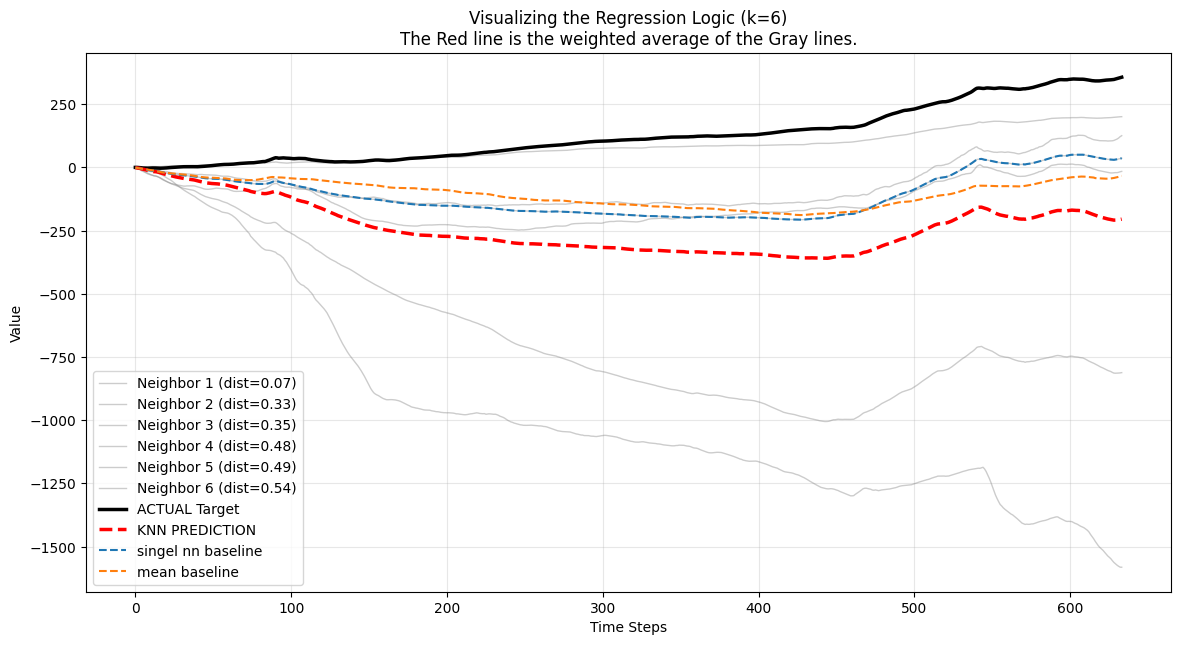

In [5]:
def optimize_and_predict_knn(df, input_cols, target_cols, test_size=0.2, val_size=0.2):
    """
    Splits data, scales inputs, finds best k, evaluates on test set, and plots a sample.
    """
    df = df.dropna(axis=0)
    X = df[input_cols].values
    Y = df[target_cols].values
    
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_size, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    
    # Optimize k
    best_k = 1
    best_mse = float('inf')
    k_values = range(1, 21) 
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn.fit(X_train_scaled, Y_train)
        preds_val = knn.predict(X_val_scaled)
        mse = mean_squared_error(Y_val, preds_val)
        
        if mse < best_mse:
            best_mse = mse
            best_k = k
            
    print(f"Best k found: {best_k} (Validation MSE: {best_mse:.4f})")
    
    
    
    X_final_train = np.vstack((X_train_scaled, X_val_scaled))
    Y_final_train = np.vstack((Y_train, Y_val))
    
    mean_baseline = np.mean(Y_train,axis=0)
    singel_nn_baseline = KNeighborsRegressor(n_neighbors=1, weights='distance')
    singel_nn_baseline.fit(X_final_train, Y_final_train)
    singel_nn_baseline_preds = singel_nn_baseline.predict(X_test_scaled)
    
    final_model = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
    final_model.fit(X_final_train, Y_final_train)
    
    test_preds = final_model.predict(X_test_scaled)
    test_mse = mean_squared_error(Y_test, test_preds)
    mean_baseline_mse = mean_squared_error(Y_test,[mean_baseline]*len(Y_test))
    singel_nn_baseline_mse = mean_squared_error(Y_test,singel_nn_baseline_preds)
    print(f"Test Set MSE: {test_mse:.4f}")
    print(f"mean baseline MSE: {mean_baseline_mse}")
    print(f"singel nn baseline MSE: {singel_nn_baseline_mse}")
    
    
    idx = 22  # We look at the first sample in the test set
    # 1. Get the indices and distances of the neighbors used
    distances, neighbor_indices = final_model.kneighbors(X_test_scaled[idx].reshape(1, -1))
    
    # neighbor_indices is a list of lists, we want the first (and only) row
    indices = neighbor_indices[0]
    dists = distances[0]

    plt.figure(figsize=(14, 7))
    # 2. Plot the Raw Data of the Neighbors
    # These are the curves the model "averaged" to get the result
    for i, neighbor_idx in enumerate(indices):
        neighbor_y = Y_final_train[neighbor_idx]
        
        # Calculate weight for legend (inverse distance)
        # Handle division by zero if distance is 0 (exact match)
        dist = dists[i]
        weight_label = f"dist={dist:.2f}"
        
        plt.plot(neighbor_y, color='gray', alpha=0.4, linewidth=1, 
                 label=f'Neighbor {i+1} ({weight_label})')

    # 3. Plot Actual vs Prediction
    plt.plot(Y_test[idx], label='ACTUAL Target', color='black', linewidth=2.5)
    plt.plot(test_preds[idx], label=f'KNN PREDICTION', color='red', linestyle='--', linewidth=2.5)
    plt.plot(singel_nn_baseline_preds[idx],label='singel nn baseline',linestyle='--')
    plt.plot(mean_baseline,label='mean baseline',linestyle='--')
    
    plt.title(f"Visualizing the Regression Logic (k={best_k})\n"
              f"The Red line is the weighted average of the Gray lines.")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return final_model, scaler, best_k, test_preds, Y_test

input_columns = ['Latitude (N)', 'Longitude (E)', 'elevation_meters']
target_columns = [c for c in df_combined.columns if c not in input_columns]
model, scaler, k, preds, actuals = optimize_and_predict_knn(df_combined, input_columns, target_columns)

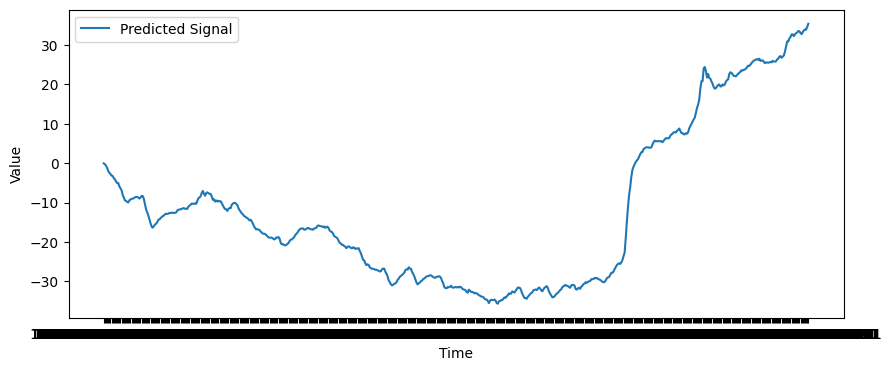

In [6]:
df = pd.read_csv("data_with_elevation.csv")
challenge_data = df.loc[990, ["Latitude (N)", "Longitude (E)", "elevation_meters"]]
single_input = np.array([challenge_data])

single_input_scaled = scaler.transform(single_input)
prediction = model.predict(single_input_scaled)
predicted_series = pd.Series(prediction.flatten(), index=target_columns)

plt.figure(figsize=(10, 4))
plt.plot(predicted_series, label='Predicted Signal')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

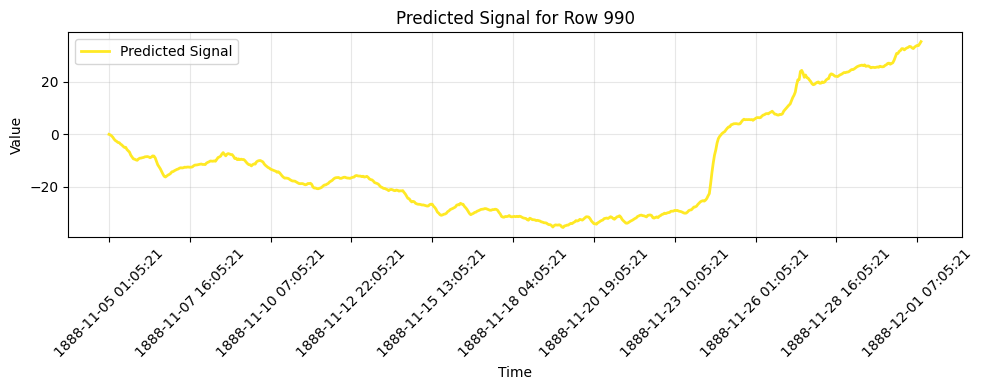

In [30]:
# ... (Previous data loading and prediction code) ...

# 1. Setup Style & Colors
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Using the dark brown/black from your palette for the main signal
c_prediction = "#ffe925" 

plt.figure(figsize=(10, 4))

# 2. Plot the Predicted Signal
plt.plot(predicted_series, 
         label='Predicted Signal', 
         color=c_prediction, 
         linewidth=2)

# 3. Formatting
plt.title(f"Predicted Signal for Row 990", color='black')
plt.xlabel("Time", color='black')
plt.ylabel("Value", color='black')

# Reduce x-ticks clutter if there are many timestamps
if len(target_columns) > 10:
    plt.xticks(np.arange(0, len(target_columns), step=len(target_columns)//10), rotation=45)

plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

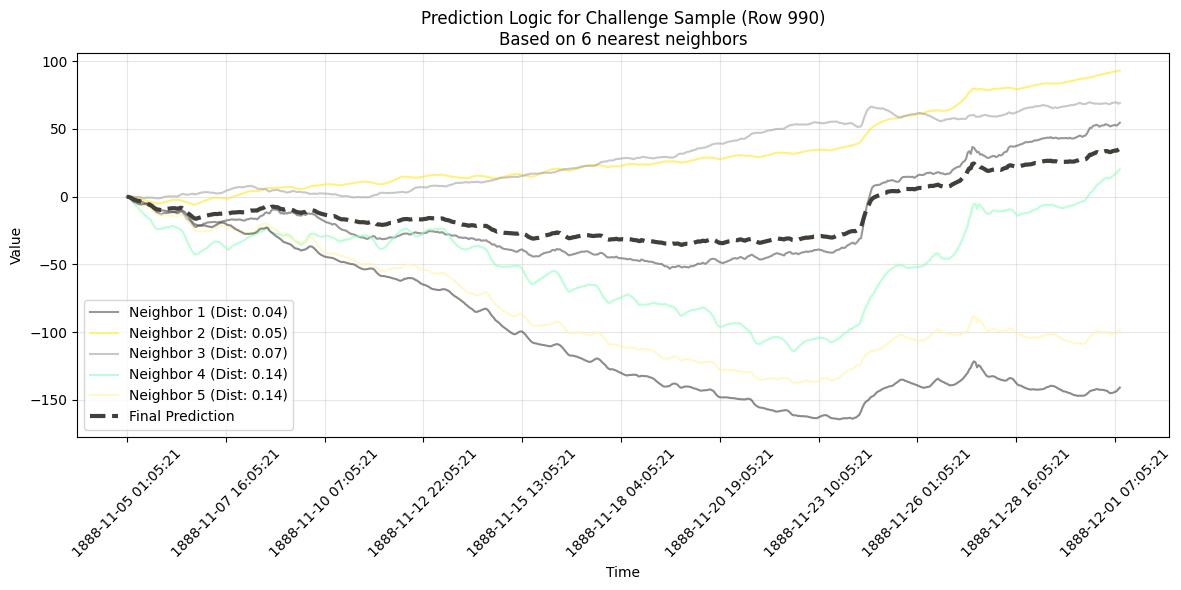

In [19]:
distances, indices = model.kneighbors(single_input_scaled)

import matplotlib.pyplot as plt
import numpy as np

# ... (Previous code: distances, indices = model.kneighbors(...) ) ...

# 1. Setup Data
neighbor_indices = indices[0]
neighbor_dists = distances[0]
training_targets = model._y

# 2. Setup the plot
plt.figure(figsize=(12, 6))

# Ensure background is white and text is black
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Combined Palette
# 1-3: Original (#545454, #f6f3d7, #a4a4a4)
# 4-6: New (#d3dad6, #423e3a, #63625c)
custom_colors = [
    "#545454", # Dark Grey
    "#ffe925", # Light Beige
    "#a4a4a4", # Medium Grey
    "#8effbfcc", # Light Grey-Green (New)
    "#fff6a8", # Light Beige
    "#423e3a"  # Very Dark Brown/Black (New)
]

for i, idx in enumerate(neighbor_indices):
    # Get the neighbor's time series
    neighbor_series = training_targets[idx]
    
    # Calculate transparency or weight label based on distance
    dist = neighbor_dists[i]
    
    # Select color by cycling through the full custom palette
    color_choice = custom_colors[i % len(custom_colors)]
    
    # Plot the neighbor
    plt.plot(target_columns, neighbor_series, color=color_choice, alpha=0.6, linewidth=1.5,
             label=f'Neighbor {i+1} (Dist: {dist:.2f})' if i < 5 else "") 

# 4. Plot the Final Prediction
# Using #423e3a (the darkest new color) for the main line to ensure it pops against the others
plt.plot(predicted_series, label='Final Prediction', color='#423e3a', linewidth=3, linestyle='--')

# 5. Formatting
plt.title(f"Prediction Logic for Challenge Sample (Row 990)\n"
          f"Based on {len(neighbor_indices)} nearest neighbors", color='black')
plt.xlabel("Time", color='black')
plt.ylabel("Value", color='black')

# Reduce x-ticks clutter if there are many timestamps
if len(target_columns) > 10:
    plt.xticks(np.arange(0, len(target_columns), step=len(target_columns)//10), rotation=45)

plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
challenge_submission = pd.read_csv("GROUPID_NICKNAME.csv")
time_series_cols = [c for c in challenge_submission.columns if c not in ['Latitude (N)', 'Longitude (E)']]
challenge_submission.loc[:, time_series_cols] = predicted_series.values
challenge_submission.to_csv("17_Test1234.csv", index=False)

## sensetivitäys analyse 

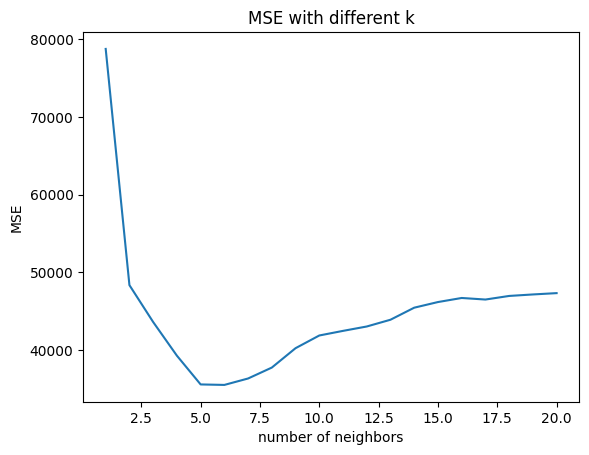

100%|██████████| 1000/1000 [00:08<00:00, 121.26it/s]


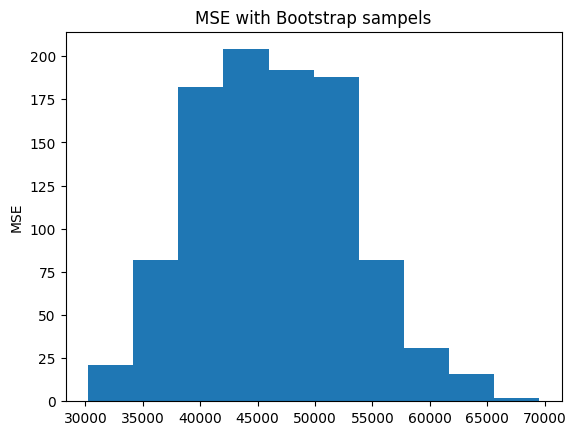

In [22]:
def sensetivity_analyse(df, input_cols, target_cols, test_size=0.2, val_size=0.2):
    """
    Splits data, scales inputs, finds best k, evaluates on test set, and plots a sample.
    """
    df = df.dropna(axis=0)
    X = df[input_cols].values
    Y = df[target_cols].values
    
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_size, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    
    # Optimize k
    best_k = 1
    best_mse = float('inf')
    k_values = range(1, 21) 
    all_mse  =[]
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn.fit(X_train_scaled, Y_train)
        preds_val = knn.predict(X_val_scaled)
        mse = mean_squared_error(Y_val, preds_val)
        all_mse.append(mse)
        
        if mse < best_mse:
            best_mse = mse
            best_k = k
    
    plt.title('MSE with different k')
    plt.xlabel('number of neighbors')
    plt.ylabel('MSE')
    plt.plot(list(k_values),all_mse)
    plt.show()
    
    all_mse  =[]
    for i in tqdm(range(1000)):
        ids = np.random.randint(0,len(X_train)-1,len(X_train))
        X_sample = X_train_scaled[ids]
        Y_sample = Y_train[ids]
        knn = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
        knn.fit(X_sample, Y_sample)
        preds_val = knn.predict(X_val_scaled)
        mse = mean_squared_error(Y_val, preds_val)
        all_mse.append(mse)
    
    plt.title('MSE with Bootstrap sampels')
    #plt.xlabel('number of neighbors')
    plt.ylabel('MSE')
    plt.hist(all_mse)
    plt.show()
    
        
        



input_columns = ['Latitude (N)', 'Longitude (E)', 'elevation_meters']
target_columns = [c for c in df_combined.columns if c not in input_columns]
sensetivity_analyse(df_combined, input_columns, target_columns)

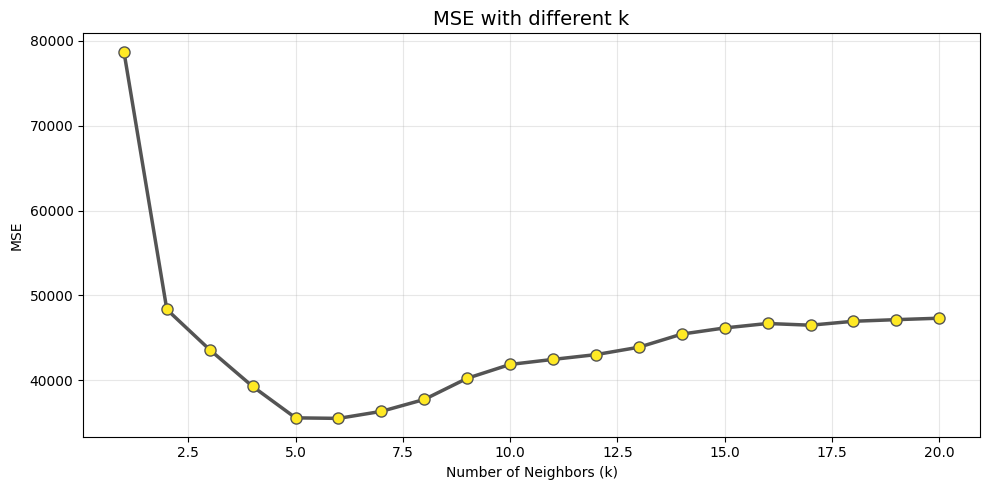

100%|██████████| 1000/1000 [00:08<00:00, 117.14it/s]


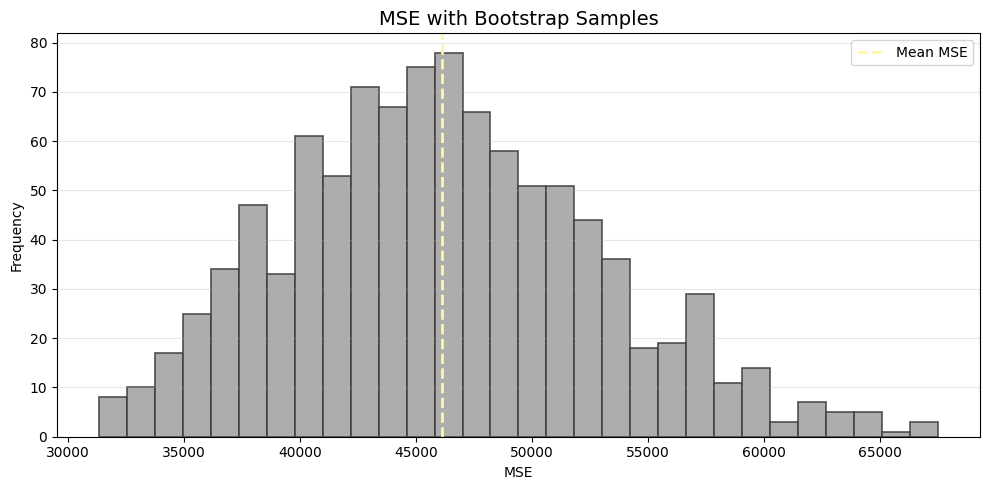

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

def sensetivity_analyse(df, input_cols, target_cols, test_size=0.2, val_size=0.2):
    """
    Splits data, scales inputs, finds best k, evaluates on test set, and plots a sample.
    """
    
    # --- 1. Style & Color Setup ---
    # Enforce white background and black text globally for this function's plots
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    
    custom_colors = [
        "#545454",   # Dark Grey
        "#ffe925",   # Bright Yellow/Beige
        "#a4a4a4",   # Medium Grey
        "#8effbfcc", # Light Grey-Green (Transparent)
        "#fff6a8",   # Light Beige
        "#423e3a"    # Very Dark Brown/Black
    ]

    # --- 2. Data Processing ---
    df = df.dropna(axis=0)
    X = df[input_cols].values
    Y = df[target_cols].values
    
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_size, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    
    # --- 3. Optimize k (Plot 1) ---
    best_k = 1
    best_mse = float('inf')
    k_values = range(1, 21) 
    all_mse  = []
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn.fit(X_train_scaled, Y_train)
        preds_val = knn.predict(X_val_scaled)
        mse = mean_squared_error(Y_val, preds_val)
        all_mse.append(mse)
        
        if mse < best_mse:
            best_mse = mse
            best_k = k
    
    # Plotting MSE vs k
    plt.figure(figsize=(10, 5))
    plt.title('MSE with different k', color='black', fontsize=14)
    plt.xlabel('Number of Neighbors (k)', color='black')
    plt.ylabel('MSE', color='black')
    
    # Line: Dark Grey, Marker: Bright Yellow with Dark Edge
    plt.plot(list(k_values), all_mse, 
             color=custom_colors[0],      # #545454 (Dark Grey)
             linewidth=2.5, 
             marker='o', 
             markersize=8,
             markerfacecolor=custom_colors[1], # #ffe925 (Bright Yellow)
             markeredgecolor=custom_colors[0]) 
             
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # --- 4. Bootstrap Analysis (Plot 2) ---
    all_mse_boot = []
    # Note: Reduced range to 100 for speed testing, revert to 1000 if needed
    for i in tqdm(range(1000)): 
        ids = np.random.randint(0, len(X_train)-1, len(X_train))
        X_sample = X_train_scaled[ids]
        Y_sample = Y_train[ids]
        
        knn = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
        knn.fit(X_sample, Y_sample)
        preds_val = knn.predict(X_val_scaled)
        mse = mean_squared_error(Y_val, preds_val)
        all_mse_boot.append(mse)
    
    # Plotting Histogram
    plt.figure(figsize=(10, 5))
    plt.title('MSE with Bootstrap Samples', color='black', fontsize=14)
    plt.ylabel('Frequency', color='black') # Changed label to Frequency for histogram
    plt.xlabel('MSE', color='black')
    
    # Histogram: Medium Grey bars with Dark Brown edges
    plt.hist(all_mse_boot, 
             bins=30, 
             color=custom_colors[2],      # #a4a4a4 (Medium Grey)
             edgecolor=custom_colors[5],  # #423e3a (Very Dark Brown)
             linewidth=1.2,
             alpha=0.9)
             
    # Optional: Add a vertical line for the mean MSE in the Green color
    plt.axvline(np.mean(all_mse_boot), color=custom_colors[4], linestyle='--', linewidth=2, label='Mean MSE')
    plt.legend()
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# Example Usage:
input_columns = ['Latitude (N)', 'Longitude (E)', 'elevation_meters']
target_columns = [c for c in df_combined.columns if c not in input_columns]
sensetivity_analyse(df_combined, input_columns, target_columns)

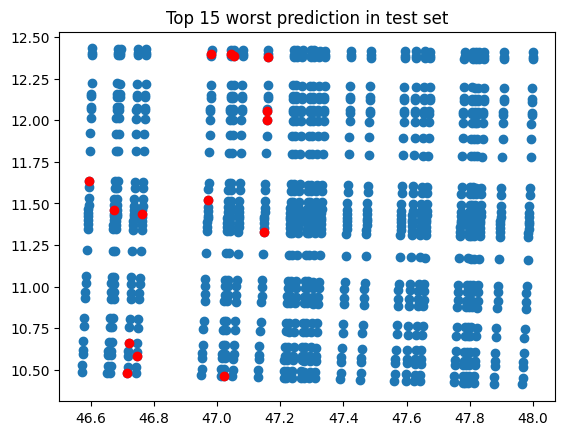

In [26]:
def fehler_analyse(df, input_cols, target_cols, test_size=0.2, val_size=0.2):
    """
    Splits data, scales inputs, finds best k, evaluates on test set, and plots a sample.
    """
    df = df.dropna(axis=0)
    X = df[input_cols].values
    Y = df[target_cols].values
    
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_size, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    
    # Optimize k
    best_k = 1
    best_mse = float('inf')
    k_values = range(1, 21) 
    all_mse  =[]
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn.fit(X_train_scaled, Y_train)
        preds_val = knn.predict(X_val_scaled)
        mse = mean_squared_error(Y_val, preds_val)
        all_mse.append(mse)
        
        if mse < best_mse:
            best_mse = mse
            best_k = k
    
    X_final_train = np.vstack((X_train_scaled, X_val_scaled))
    Y_final_train = np.vstack((Y_train, Y_val))
    
    #mean_baseline = np.mean(Y_train,axis=0)
    #singel_nn_baseline = KNeighborsRegressor(n_neighbors=1, weights='distance')
    #singel_nn_baseline.fit(X_final_train, Y_final_train)
    #singel_nn_baseline_preds = singel_nn_baseline.predict(X_test_scaled)
    
    final_model = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
    final_model.fit(X_final_train, Y_final_train)
    
    test_preds = final_model.predict(X_test_scaled)
    all_mse = []
    for i in range(len(Y_test)):
        all_mse.append(mean_squared_error(Y_test[i],test_preds[i]))
        
    test_mse = mean_squared_error(Y_test, test_preds)
    #mean_baseline_mse = mean_squared_error(Y_test,[mean_baseline]*len(Y_test))
    all_test_mse = {}
    k = 15

    for i in range(len(X_test)):
        all_test_mse[tuple(X_test[i])] = all_mse[i]
    plt.scatter(df_combined[['Latitude (N)']],df_combined[[ 'Longitude (E)']])   
    sortet_mse = {w: all_test_mse[w] for w in sorted(all_test_mse, key=all_test_mse.get, reverse=True)}
    for i in list(sortet_mse.keys())[:k]:
        plt.scatter(i[0],i[1],color='r')
    plt.title(f'Top {k} worst prediction in test set')
    #return (X_test,all_mse)
    
    
    

input_columns = ['Latitude (N)', 'Longitude (E)', 'elevation_meters']
target_columns = [c for c in df_combined.columns if c not in input_columns]
fehler_analyse(df_combined, input_columns, target_columns)


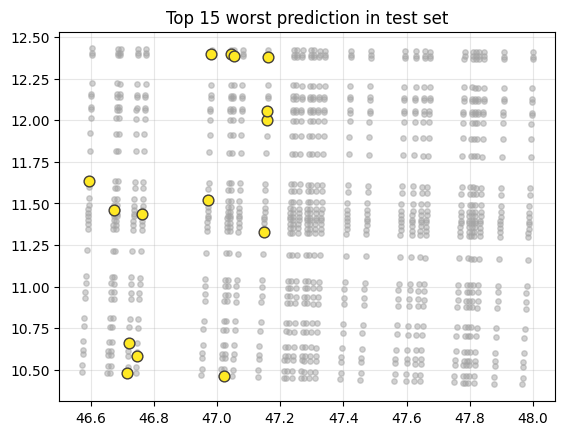

In [28]:
def fehler_analyse(df, input_cols, target_cols, test_size=0.2, val_size=0.2):
    """
    Splits data, scales inputs, finds best k, evaluates on test set, and plots a sample.
    """
    # --- Color Setup ---
    # Global plot settings for White Background / Black Text
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'

    # Palette
    c_bg_points = "#a4a4a4"   # Medium Grey (for the map)
    c_error     = "#ffe925"   # Light Beige/Yellow (for the errors)
    c_edge      = "#423e3a"   # Dark Brown (for borders/text)

    df = df.dropna(axis=0)
    X = df[input_cols].values
    Y = df[target_cols].values
    
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_size, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    
    # Optimize k
    best_k = 1
    best_mse = float('inf')
    k_values = range(1, 21) 
    all_mse  =[]
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn.fit(X_train_scaled, Y_train)
        preds_val = knn.predict(X_val_scaled)
        mse = mean_squared_error(Y_val, preds_val)
        all_mse.append(mse)
        
        if mse < best_mse:
            best_mse = mse
            best_k = k
    
    X_final_train = np.vstack((X_train_scaled, X_val_scaled))
    Y_final_train = np.vstack((Y_train, Y_val))
    
    #mean_baseline = np.mean(Y_train,axis=0)
    #singel_nn_baseline = KNeighborsRegressor(n_neighbors=1, weights='distance')
    #singel_nn_baseline.fit(X_final_train, Y_final_train)
    #singel_nn_baseline_preds = singel_nn_baseline.predict(X_test_scaled)
    
    final_model = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
    final_model.fit(X_final_train, Y_final_train)
    
    test_preds = final_model.predict(X_test_scaled)
    all_mse = []
    for i in range(len(Y_test)):
        all_mse.append(mean_squared_error(Y_test[i],test_preds[i]))
        
    test_mse = mean_squared_error(Y_test, test_preds)
    #mean_baseline_mse = mean_squared_error(Y_test,[mean_baseline]*len(Y_test))
    all_test_mse = {}
    k = 15

    for i in range(len(X_test)):
        all_test_mse[tuple(X_test[i])] = all_mse[i]
    
    # 1. Plot Background (Medium Grey)
    plt.scatter(df_combined[['Latitude (N)']], df_combined[['Longitude (E)']], 
                color=c_bg_points, alpha=0.5, s=15, label='All Data')   
    
    sortet_mse = {w: all_test_mse[w] for w in sorted(all_test_mse, key=all_test_mse.get, reverse=True)}
    
    # 2. Plot Worst Errors (Yellow with Dark Border)
    for i in list(sortet_mse.keys())[:k]:
        plt.scatter(i[0], i[1], color=c_error, edgecolor=c_edge, s=60, zorder=5)
        
    plt.title(f'Top {k} worst prediction in test set', color='black')
    
    # Formatting
    plt.grid(True, alpha=0.3)
    #return (X_test,all_mse)

input_columns = ['Latitude (N)', 'Longitude (E)', 'elevation_meters']
target_columns = [c for c in df_combined.columns if c not in input_columns]
fehler_analyse(df_combined, input_columns, target_columns)